In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image
from numpy import array

import cv2
import numpy as np

from torchvision.utils import save_image
import torch
import matplotlib

In [3]:
def assignFlowToSegs(segs, flow, nchannels):
    """
    Maps a tensor flow of shape (nx, ny, nv)
    using a tensor segs of shape (1, nx, ny)
    with discrete values in the range(nchannels)
    onto a onehot style tensor of shape (nchannels, nv, nx, ny)
    """
    nx, ny, nv = flow.shape
    x,y = np.meshgrid(np.arange(nx), np.arange(ny))
    res = np.zeros((nchannels, nv, nx, ny))
    res[segs.T.ravel(), :, x.ravel(), y.ravel()] = flow[x.ravel(), y.ravel(), :]
    return res

In [4]:
def segs2onehot(frame, nchannels):
    """
    Converts a tensor of shape (1, imgx, imgy)
    with discrete values in the range(nchannels)
    to a onehot style tensor of shape (nchannels, imgx, imgy)
    """
    *_, nx, ny = frame.shape
    x,y = np.meshgrid(np.arange(nx), np.arange(ny))
    res = np.zeros((nchannels, nx, ny))
    res[frame.T.ravel(), x.ravel(), y.ravel()] = 1
    return res

### Import Segmented Image

*** remember you need only ONE channel from segmented image

In [5]:
im = cv2.imread('segImage1.png')

In [6]:
im.shape

(360, 480, 3)

### Separate one channel from im

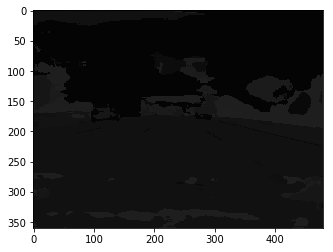

In [7]:
plt.imshow(im)

In [8]:
# Create new image with one channel 
new_im = im[:, : , 2]

In [9]:
new_im.shape

(360, 480)

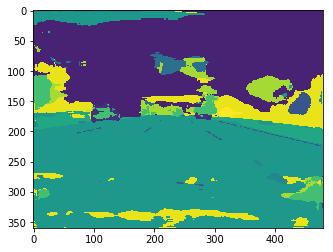

In [10]:
plt.imshow(new_im)

In [11]:
im = new_im

In [12]:
im.shape

(360, 480)

### One-Hot (Torch Version) - Segmented image

In [14]:
torchExFloatTensor = torch.from_numpy(new_im)

In [15]:
torchExFloatTensor.shape

torch.Size([360, 480])

In [16]:
one_hot = torch.nn.functional.one_hot(torchExFloatTensor.to(torch.int64), 32)

In [17]:
type(one_hot)

torch.Tensor

In [18]:
one_hot.shape

torch.Size([360, 480, 32])

## Import Optical flow matrices
- each .npy file has 1000 opt flow matrices 

In [22]:
optFlowFirstThousand = np.load('optFlowMat1.npy')

In [23]:
type(optFlowFirstThousand)

numpy.ndarray

##### Single out first matrix

In [24]:
optFlow1 = optFlowFirstThousand[0]

In [60]:
np.save(f'optFlowFirstMatrix.npy', optFlow1)

In [61]:
optFlow1.shape

(2, 360, 480)

In [62]:
optFlow1.shape

(2, 360, 480)

In [63]:
test = torch.transpose(optFlowTensor, 0, 2)

In [64]:
test.shape

torch.Size([2, 480, 360])

In [65]:
optFlowTensor = torch.transpose(test, 0,1); optFlowTensor.shape

torch.Size([480, 2, 360])

### Convert optFlow1 into a tensor

In [28]:
optFlowTensor = torch.from_numpy(optFlow1)

In [55]:
optFlowTensor.shape

torch.Size([360, 480, 2])

### One-hot segmented tensor converted into Byte Tensor 

In [30]:
oneHotByte = one_hot.type(torch.ByteTensor)

In [31]:
type(oneHotByte)

torch.Tensor

In [32]:
oneHotByte.shape

torch.Size([360, 480, 32])

### Combine: vector = optFlowTensor X oneHotByte

In [59]:
vector = torch.matmul(oneHotByte, optFlowTensor)

RuntimeError: Expected tensor to have size 32 at dimension 1, but got size 480 for argument #2 'batch2' (while checking arguments for bmm)

## Pool vector

## Take cartesian coordinates in vector, then convert to polar coordinates

### Create a datablock with new images and txt file

In [133]:
# path = /home/jupyter.../vectorImages
path = ...

In [136]:
# Labels 

labels_folder_path = ...

In [134]:
tfms = get_transforms(do_flip=False)

In [ ]:
# Fix this
data = (ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)
       .from_folder(labels_folder_path)
       .split_subsets(train_size=0.7, valid_size=0.3, seed=None))

### GRU Version

In [83]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input to Hidden layer
        self.i_h = nn.Embedding(nv,nh)
        
        # RNN 
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        
        # Hidden layer to output
        self.h_o = nn.Linear(nh,nv)
        
        # Batchnore 1D-flat 
        self.bn = BatchNorm1dFlat(nh)
        
        # Hidden layer 
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [ ]:
learn = Learner(data, Model5(), metrics=accuracy)

In [158]:
mtest = np.load('opticalFlowMatrices.npy')

ValueError: Cannot load file containing pickled data when allow_pickle=False